# Импорт необхдимых библиотек

In [1]:
!pip install -U git+https://github.com/rwightman/pytorch-image-models

  Cloning https://github.com/rwightman/pytorch-image-models to /tmp/pip-req-build-jb6btbfn
  Running command git clone -q https://github.com/rwightman/pytorch-image-models /tmp/pip-req-build-jb6btbfn
  Created wheel for timm: filename=timm-0.4.8-py3-none-any.whl size=328816 sha256=9e5243bfb5060e6bab4db700f02f52a11dd7ad95402d82bcc78f36104113629c
  Stored in directory: /tmp/pip-ephem-wheel-cache-loumyd5_/wheels/69/3d/b0/be55cbadabd87a0e1875d63c7492d199097a39cc2433637650
Successfully built timm


In [2]:
# import time
# import datetime
# import copy
# import matplotlib.pyplot as plt
# import json
# import seaborn as sns
# import cv2
# import albumentations as albu
# import numpy as np
# from PIL import Image
# import pytorch_lightning as pl
# import os
# import pandas as pd


# import torch
# import torch.nn as nn
# import torchvision.models as models
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, train_test_split

# import albumentations

# from albumentations import (
#     HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
#     Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
#     IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
#     IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
# )
    
# from albumentations.pytorch import ToTensorV2

In [3]:
import pandas as pd
import numpy as np
import cv2
import timm
import torch
import torch.nn as nn
import albumentations as A
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torchmetrics
import os
from PIL import Image

from torch.utils.data import Dataset, DataLoader
from albumentations.core.composition import Compose, OneOf
from albumentations.pytorch import ToTensorV2

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning import Callback
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import StratifiedKFold

# ***Для начала загрузим и изучим данные***

In [4]:
DEBUG = False

In [5]:
PATH = '../input/plant-pathology-2021-fgvc8/'

# TRAIN_DIR = PATH + 'train_images/'
# TRAIN_DIR = '../input/resized-plant2021/img_sz_640/'
TEST_DIR = PATH + 'test_images/'

In [6]:
train_df = pd.read_csv(os.path.join(PATH, 'train.csv'))
train_df.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [7]:
print("Count of training images {0}".format(len(os.listdir(os.path.join(PATH,'train_images')))))

Count of training images 18632


In [8]:
from itertools import chain

def flatmap(f, items):
    return chain.from_iterable(map(f, items))

In [9]:
def label_splitter(labels):
    return labels.split(' ')

In [10]:
# Посмотрим сколько уникальных комбинаций меток есть в датасете

m_uniq = train_df['labels'].unique()

print('Length: ', len(m_uniq))
print('Метки:', *m_uniq, sep='\n')

Length:  12
Метки:
healthy
scab frog_eye_leaf_spot complex
scab
complex
rust
frog_eye_leaf_spot
powdery_mildew
scab frog_eye_leaf_spot
frog_eye_leaf_spot complex
rust frog_eye_leaf_spot
powdery_mildew complex
rust complex


In [11]:
categories_foliage_deseases = set(flatmap(label_splitter, m_uniq))

print('Length: ', len(categories_foliage_deseases))

print('Categories foliage deseases:', *categories_foliage_deseases, sep='\n')
"""
A majority of the pictures taken were of apple:
scab, 
cedar apple rust, 
Alternaria leaf spot, 
frogeye leaf spot, 
and healthy leaves.
"""

Length:  6
Categories foliage deseases:
scab
powdery_mildew
frog_eye_leaf_spot
complex
rust
healthy


'\nA majority of the pictures taken were of apple:\nscab, \ncedar apple rust, \nAlternaria leaf spot, \nfrogeye leaf spot, \nand healthy leaves.\n'

1. healthy - полностью здоровое растение

2. complex - множественные, комплексные заболевания у растения

3. powdery_mildew - Мучнистая роса, пепелица, бель — грибное заболевание растений, вызываемое микроскопическими эктопаразитическими грибами из порядка эризифовых, или мучнисторосяных. Мицелий мучнисто-белого цвета развивается на листьях, надземных частях побегов, иногда на плодах в начале лета.

4. rust или Cedar-apple rust - Gymnosporangium juniperi-virginianae - это растительный патоген, вызывающий кедрово-яблочную ржавчину. Практически в любом месте, где сосуществуют яблоки или яблоки и восточный красный кедр, ржавчина кедрового яблока может быть разрушительной или уродующей болезнью как яблок, так и кедров.

5. scab - Парша яблони — заболевание и повреждения на листьях и плодах яблони, вызываемые сумчатым грибом Venturia inaequalis. Парша широко распространена в умеренном климате, особенно в районах с холодной влажной весной. В благоприятные для развития гриба годы она сильно снижает качество и урожай яблок.

6. frog_eye_leaf_spot - Черная гниль и пятнистость листьев лягушки - фазы широко распространенного и опасного заболевания яблони и яблони. Фаза плодовой гнили называется черной гнилью, а на листе - пятнистостью листа. Болезнь может приводить к потерям из-за гниения плодов перед сбором урожая и при хранении, ослаблению дерева из-за дефолиации, а также к упадку и отмиранию веток и ветвей, вызванным опоясывающими язвами. Преждевременное опадание инфицированных листьев может привести к появлению мелких, некачественных плодов и снижению урожайности в следующем году. Все сорта яблок одинаково подвержены гниению плодов.

In [12]:
print('Length: ', len(train_df['labels'].unique()))
print('Labels: ', *train_df['labels'].unique(), sep = '\n')

Length:  12
Labels: 
healthy
scab frog_eye_leaf_spot complex
scab
complex
rust
frog_eye_leaf_spot
powdery_mildew
scab frog_eye_leaf_spot
frog_eye_leaf_spot complex
rust frog_eye_leaf_spot
powdery_mildew complex
rust complex


In [13]:
def show_images(class_name, examples=2, labels_df=train_df, train_images_path=PATH + 'train_images/'):
    image_list = labels_df[labels_df['labels'] == class_name]['image'].sample(frac=1)[:examples].to_list()
    plt.figure(figsize=(20,10))
    for i, img in enumerate(image_list):
        full_path = os.path.join(train_images_path, img)
        img = Image.open(full_path)
        plt.subplot(1 ,examples, i%examples +1)
        plt.axis('off')
        plt.imshow(img)
        plt.title(class_name)

In [14]:
def show_image(image_name, data=train_df, path=PATH + 'train_images/'):
    
    plt.figure(figsize=(15,7))
    
    full_path = os.path.join(path, image_name)
    image = Image.open(full_path)
    plt.axis('off')
    plt.imshow(image)
    title = data[data['image'].str.contains(image_name)]['labels'].values[0]

    plt.title(title)

In [15]:
image0 = train_df['image'][0]
image0

'800113bb65efe69e.jpg'

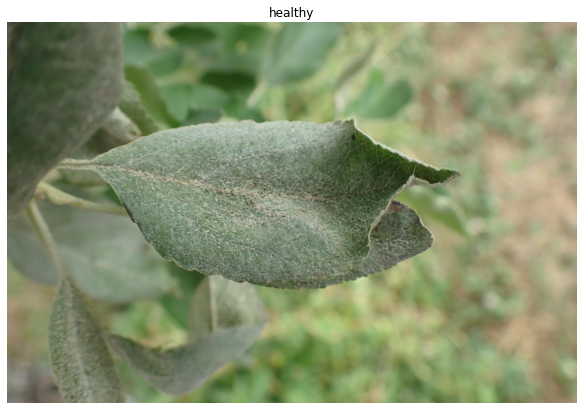

In [16]:
show_image(image0)

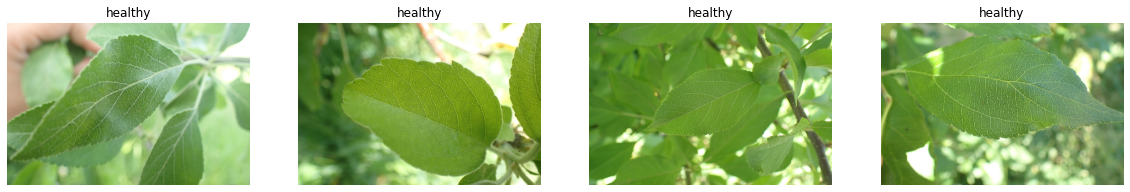

In [17]:
show_images(class_name='healthy', examples=4)

In [18]:
def recode_dataset(data):
    train_data = pd.DataFrame(columns=['image', 'label'])

    for image in data['image'].values:

        string_of_labels = data[data['image'].str.contains(image)]['labels'].values[0]
        
        array_of_image_labels = label_splitter(string_of_labels)
        for label in array_of_image_labels:
            
            series = pd.Series([image, label], index = train_data.columns)

            train_data = train_data.append(series, ignore_index=True)
            
    return train_data

In [19]:
train_df

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


In [20]:
len(categories_foliage_deseases)

6

In [21]:
# labels = train_df['labels'].str.split(" ").apply(pd.Series, 1).stack()
# labels.index = labels.index.droplevel(-1)
# target_labels = pd.get_dummies(labels).groupby(level=0).sum()

In [22]:
for label in categories_foliage_deseases:
    train_df[label] = train_df['labels'].str.contains(label).astype('int')

train_df

,image,labels,scab,powdery_mildew,frog_eye_leaf_spot,complex,rust,healthy
0,800113bb65efe69e.jpg,healthy,0,0,0,0,0,1
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,1,0,1,1,0,0
2,80070f7fb5e2ccaa.jpg,scab,1,0,0,0,0,0
3,80077517781fb94f.jpg,scab,1,0,0,0,0,0
4,800cbf0ff87721f8.jpg,complex,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
18627,fffb900a92289a33.jpg,healthy,0,0,0,0,0,1
18628,fffc488fa4c0e80c.jpg,scab,1,0,0,0,0,0
18629,fffc94e092a59086.jpg,rust,0,0,0,0,1,0
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot,1,0,1,0,0,0


In [23]:
import albumentations as A

In [24]:
def get_transform(phase: str):
    if phase == 'train':
        return Compose([
            A.RandomResizedCrop(height=CFG.img_size, width=CFG.img_size),
            A.Flip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.HueSaturationValue(p=0.5),
            A.OneOf([
                A.RandomBrightnessContrast(p=0.5),
                A.RandomGamma(p=0.5),
            ], p=0.5),
            A.OneOf([
                A.Blur(p=0.1),
                A.GaussianBlur(p=0.1),
                A.MotionBlur(p=0.1),
            ], p=0.1),
            A.OneOf([
                A.GaussNoise(p=0.1),
                A.ISONoise(p=0.1),
                A.GridDropout(ratio=0.5, p=0.2),
                A.CoarseDropout(max_holes=16, min_holes=8, max_height=16, max_width=16, min_height=8, min_width=8, p=0.2)
            ], p=0.2),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    else:
        return Compose([
            A.Resize(height=CFG.img_size, width=CFG.img_size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [25]:
class CFG:
    seed = 42
    model_name = 'resnet50'
    pretrained = True
    img_size = 512
    num_classes = 6
    lr = 1e-4
    max_lr = 1e-3
    pct_start = 0.3
    div_factor = 1.0e+3
    final_div_factor = 1.0e+3
    num_epochs = 5
    batch_size = 16
    accum = 1
    precision = 16
    n_fold = 5
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [26]:
CFG.device

device(type='cuda', index=0)

In [27]:
skf = StratifiedKFold(CFG.n_fold)
for train_idx, valid_idx in skf.split(train_df['image'], train_df['labels']):
    train_data = train_df.iloc[train_idx]
    valid_data = train_df.iloc[valid_idx]
    break
    
print(f"train size: {len(train_data)}")
print(f"valid size: {len(valid_data)}")

train size: 14905
valid size: 3727


In [28]:
from fastai.vision.all import *
data_path = Path('../input/resized-plant2021/img_sz_640/')

In [29]:
from skimage import io

In [30]:
class PlantDataset(Dataset):
    def __init__(self, df, transform=None):
        self.image_id = df['image'].values
        self.labels = df.iloc[:, 2:].values
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        image_id = self.image_id[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        #print('idx = ', str(idx), ' image_id = ', image_id)
        #image_path = TRAIN_DIR + image_id
        image_path = PATH + 'train_images/' + image_id
        image = cv2.imread(image_path)
        #image = io.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        augmented = self.transform(image=image)
        image = augmented['image']
        return {'image':image, 'target': label}

In [31]:
d = PlantDataset(train_data, get_transform('train'))
d.__getitem__(95)

{'image': tensor([[[ 0.3652, -0.0287, -0.3712,  ..., -0.3883, -0.1828, -0.0116],
          [ 0.0398,  0.1597, -0.0801,  ..., -0.4568, -0.2684, -0.0629],
          [-0.1143, -0.0972, -0.1657,  ..., -0.2856, -0.2342, -0.0458],
          ...,
          [ 0.4337,  0.3994,  0.3309,  ...,  0.7419,  0.5707,  0.3652],
          [ 0.4508,  0.3994,  0.3481,  ...,  0.7248,  0.6221,  0.5022],
          [ 0.4508,  0.4166,  0.3994,  ...,  0.6392,  0.5707,  0.5536]],
 
         [[ 0.4503,  0.0476, -0.2500,  ..., -0.1975, -0.0224,  0.1352],
          [ 0.1352,  0.2227, -0.0049,  ..., -0.3025, -0.0924,  0.0651],
          [ 0.0126, -0.0399, -0.1099,  ..., -0.1625, -0.0749,  0.1352],
          ...,
          [ 0.4503,  0.4153,  0.3277,  ...,  0.6429,  0.4153,  0.1702],
          [ 0.4678,  0.4153,  0.3102,  ...,  0.5903,  0.4328,  0.3452],
          [ 0.5028,  0.4678,  0.3627,  ...,  0.4853,  0.3978,  0.3978]],
 
         [[ 0.0779, -0.3230, -0.6541,  ..., -0.5147, -0.3230, -0.1487],
          [-0.2532,

In [32]:
train_dataset = PlantDataset(train_data, get_transform('train'))
valid_dataset = PlantDataset(valid_data, get_transform('valid'))

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=2, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=2)

In [33]:
import torch.nn.functional as F


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
            #BCE_loss = nn.BCEWithLogitsLoss(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
            #BCE_loss = nn.BCEWithLogitsLoss(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [34]:
class CustomResNet(nn.Module):
    def __init__(self, model_name='resnet18', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.model.get_classifier().in_features
#         self.model.fc = nn.Linear(in_features, CFG.num_classes)
        self.model.fc = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features, CFG.num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [35]:
CFG.steps_per_epoch = len(train_loader)

In [36]:
class LitCassava(pl.LightningModule):
    def __init__(self, model):
        super(LitCassava, self).__init__()
        self.model = model
        self.metric = pl.metrics.F1(num_classes=CFG.num_classes)
        self.criterion = nn.BCELoss()
        self.sigmoid = nn.Sigmoid()
        self.lr = CFG.lr

    def forward(self, x, *args, **kwargs):
        return self.model(x)

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, 
                                                             epochs=CFG.num_epochs, steps_per_epoch=CFG.steps_per_epoch,
                                                             max_lr=CFG.max_lr, pct_start=CFG.pct_start, 
                                                             div_factor=CFG.div_factor, final_div_factor=CFG.final_div_factor)


        return [self.optimizer], [{'scheduler': self.scheduler, 'interval': 'step'}]

    def training_step(self, batch, batch_idx):
        image = batch['image']
        target = batch['target']
        output = self.model(image)
        # output = self.sigmoid(output)
        # loss = self.criterion(output, target)
        loss = F.binary_cross_entropy_with_logits(output, target)
        score = self.metric(output, target)
        logs = {'train_loss': loss, 'train_f1': score, 'lr': self.optimizer.param_groups[0]['lr']}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss
    
    def validation_step(self, batch, batch_idx):
        image = batch['image']
        target = batch['target']
        output = self.model(image)
        #output = self.sigmoid(output)
        #loss = self.criterion(output, target)
        loss = F.binary_cross_entropy_with_logits(output, target)
        score = self.metric(output, target)
        logs = {'valid_loss': loss, 'valid_f1': score}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

In [37]:
model = CustomResNet(model_name=CFG.model_name, pretrained=CFG.pretrained)
lit_model = LitCassava(model.model)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_ram-a26f946b.pth


In [38]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

In [39]:
logger = CSVLogger("logs/", name=CFG.model_name)
logger.log_hyperparams(CFG.__dict__)
checkpoint_callback = ModelCheckpoint(monitor='valid_f1',
                                      save_top_k=1,
                                      save_last=True,
                                      save_weights_only=True,
                                      filename='{epoch:02d}-{valid_loss:.4f}-{valid_f1:.4f}',
                                      verbose=False,
                                      mode='max')

trainer = Trainer(
    max_epochs=CFG.num_epochs,
    gpus=-1,
    accumulate_grad_batches=CFG.accum,
    precision=CFG.precision,
#     callbacks=[EarlyStopping(monitor='valid_loss', patience=3, mode='min')],
    checkpoint_callback=checkpoint_callback,
    logger=logger,
    weights_summary='top',
)

In [40]:
trainer.fit(lit_model, train_dataloader=train_loader, val_dataloaders=valid_loader)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/saving.py:402: UserWarning: Skipping '__dict__' parameter because it is not possible to safely dump to YAML.
  warn(f"Skipping '{k}' parameter because it is not possible to safely dump to YAML.")
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/saving.py:402: UserWarning: Skipping '__weakref__' parameter because it is not possible to safely dump to YAML.
  warn(f"Skipping '{k}' parameter because it is not possible to safely dump to YAML.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

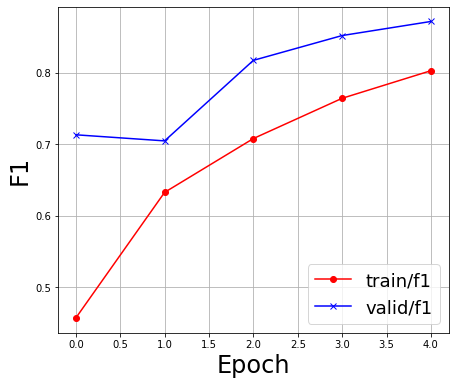

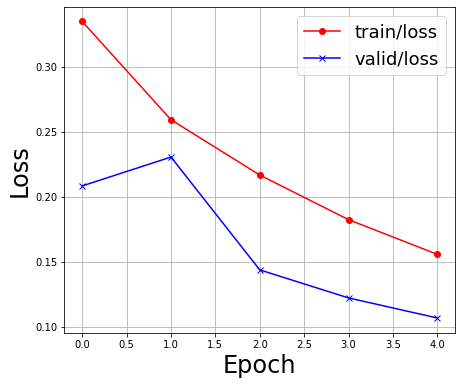

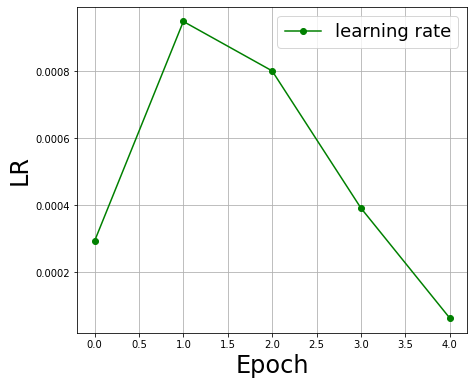

In [41]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

train_acc = metrics['train_f1'].dropna().reset_index(drop=True)
valid_acc = metrics['valid_f1'].dropna().reset_index(drop=True)
    
fig = plt.figure(figsize=(7, 6))
plt.grid(True)
plt.plot(train_acc, color="r", marker="o", label='train/f1')
plt.plot(valid_acc, color="b", marker="x", label='valid/f1')
plt.ylabel('F1', fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.legend(loc='lower right', fontsize=18)
plt.savefig(f'{trainer.logger.log_dir}/f1.png')

train_loss = metrics['train_loss'].dropna().reset_index(drop=True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop=True)

fig = plt.figure(figsize=(7, 6))
plt.grid(True)
plt.plot(train_loss, color="r", marker="o", label='train/loss')
plt.plot(valid_loss, color="b", marker="x", label='valid/loss')
plt.ylabel('Loss', fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.legend(loc='upper right', fontsize=18)
plt.savefig(f'{trainer.logger.log_dir}/loss.png')\

lr = metrics['lr'].dropna().reset_index(drop=True)

fig = plt.figure(figsize=(7, 6))
plt.grid(True)
plt.plot(lr, color="g", marker="o", label='learning rate')
plt.ylabel('LR', fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.legend(loc='upper right', fontsize=18)
plt.savefig(f'{trainer.logger.log_dir}/lr.png')

In [55]:
checkpoint_callback.best_model_path

'logs/resnet50/version_0/checkpoints/epoch=04-valid_loss=0.1066-valid_f1=0.8716.ckpt'

In [54]:
torch.save(model.state_dict(), 'res_net_model_state_dict.pt')
torch.save(lit_model.state_dict(), 'lit_model_state_dict.pt')

In [58]:
res_net_model_state_dict = torch.load('res_net_model_state_dict.pt')
new_res_net_model = CustomResNet(model_name=CFG.model_name, pretrained=CFG.pretrained)
new_res_net_model.load_state_dict(res_net_model_state_dict)

<All keys matched successfully>

In [60]:
lit_model_state_dict = torch.load('lit_model_state_dict.pt')
new_lit_model = LitCassava(new_res_net_model.model)
new_lit_model.load_state_dict(lit_model_state_dict)

<All keys matched successfully>

In [63]:
d = PlantDataset(train_data, get_transform('train'))
item = d.__getitem__(95)

item

{'image': tensor([[[ 0.6049,  0.6392,  0.6906,  ..., -0.0801, -0.0801, -0.0458],
          [ 0.5878,  0.6221,  0.6392,  ..., -0.0972, -0.0972, -0.0801],
          [ 0.5364,  0.5536,  0.6221,  ..., -0.0801, -0.0801, -0.1314],
          ...,
          [ 0.6563,  0.6734,  0.6906,  ..., -1.1075, -1.0390, -1.0390],
          [ 0.6734,  0.6906,  0.6906,  ..., -1.1418, -1.1247, -1.1075],
          [ 0.6906,  0.7248,  0.7077,  ..., -1.1589, -1.1247, -1.0562]],
 
         [[ 1.1506,  1.2031,  1.2206,  ...,  0.7129,  0.7129,  0.7479],
          [ 1.1506,  1.1681,  1.2031,  ...,  0.6954,  0.7129,  0.7129],
          [ 1.1155,  1.1155,  1.1856,  ...,  0.7129,  0.7129,  0.6779],
          ...,
          [ 1.4832,  1.4832,  1.4832,  ...,  0.0826,  0.1176,  0.0826],
          [ 1.4832,  1.4832,  1.4832,  ...,  0.0651,  0.0476,  0.0301],
          [ 1.4832,  1.5182,  1.5007,  ...,  0.0651,  0.0651,  0.0476]],
 
         [[ 0.9842,  1.0365,  1.0714,  ...,  0.2696,  0.2696,  0.3045],
          [ 0.9842,

In [181]:
sub = pd.read_csv(PATH + "sample_submission.csv")
sub.head()

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [182]:
tmp = pd.DataFrame(np.zeros([len(sub), len(train_data.columns)]), columns=train_data.columns)
sub = pd.concat([sub, tmp], axis=1)
sub.head()

,image,labels,image,labels,scab,powdery_mildew,frog_eye_leaf_spot,complex,rust,healthy
0,85f8cb619c66b863.jpg,healthy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ad8770db05586b59.jpg,healthy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,c7b03e718489f3ca.jpg,healthy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [183]:
def get_transform_sub(phase: str):
    if phase == 'train':
        return Compose([
            A.RandomResizedCrop(height=CFG.img_size, width=CFG.img_size),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Normalize(),
            ToTensorV2(),
        ])
    else:
        return Compose([
            A.Resize(height=CFG.img_size, width=CFG.img_size),
            A.Normalize(),
            ToTensorV2(),
        ])

In [184]:
class PlantDatasetSub(Dataset):
    def __init__(self, df, transform=None):
        self.image_id = df['image'].values
        self.labels = df.iloc[:, 2:].values
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_id = self.image_id[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        #print(image_id[0])
        image_path = TEST_DIR + image_id[0]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        augmented = self.transform(image=image)
        image = augmented['image']
        return {'image':image, 'target': label}

In [185]:
dsub = PlantDatasetSub(sub, get_transform('valid'))
item0 = dsub.__getitem__(0)

item0

{'image': tensor([[[ 1.1872,  1.2043,  1.2043,  ..., -1.2445, -1.2274, -1.1932],
          [ 1.2043,  1.2214,  1.1700,  ..., -1.1075, -1.0904, -0.9705],
          [ 1.2214,  1.2385,  1.2043,  ..., -0.9534, -0.8164, -0.6965],
          ...,
          [-1.5357, -1.4500, -1.5699,  ...,  1.1358,  1.2385,  1.4440],
          [-1.5870, -1.5699, -1.5357,  ...,  1.1529,  1.2728,  1.4098],
          [-1.5870, -1.5699, -1.5870,  ...,  1.1529,  1.2728,  1.4098]],
 
         [[ 1.5707,  1.5882,  1.5882,  ..., -0.7577, -0.7402, -0.7052],
          [ 1.5882,  1.6057,  1.6232,  ..., -0.6176, -0.6001, -0.4601],
          [ 1.6583,  1.6758,  1.6583,  ..., -0.4951, -0.4426, -0.3025],
          ...,
          [-1.0903, -1.0553, -1.0728,  ...,  0.9930,  1.1506,  1.2906],
          [-1.0903, -1.0728, -1.0378,  ...,  1.0105,  1.1155,  1.2556],
          [-1.0903, -1.0553, -1.0378,  ...,  1.0280,  1.1155,  1.2556]],
 
         [[ 1.6117,  1.6291,  1.6465,  ..., -1.1596, -1.1421, -1.1596],
          [ 1.6291,

In [186]:
test_data = PlantDatasetSub(sub, get_transform_sub('valid'))
test_loader = DataLoader(test_data, batch_size=CFG.batch_size, shuffle=False, num_workers=2)

In [187]:
new_lit_model.cuda()
new_lit_model.eval()

sigmoid = nn.Sigmoid()

predictions = []
for batch in test_loader:
    image = batch['image'].cuda()
    with torch.no_grad():
        outputs = new_lit_model(image)
        preds = outputs.detach().cpu()
        predictions.append(sigmoid(preds).numpy() > 0.5)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73cf091d40>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73cf091d40>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join

In [188]:
predictions

[array([[ True, False, False, False, False, False],
        [False, False, False,  True, False, False],
        [False, False,  True, False, False, False]])]

In [189]:
train_data.columns[2:]

Index(['scab', 'powdery_mildew', 'frog_eye_leaf_spot', 'complex', 'rust',
       'healthy'],
      dtype='object')

In [190]:
predictions = pd.DataFrame(np.concatenate(predictions).astype(np.int), columns=train_data.columns[2:])

In [191]:
predictions

,scab,powdery_mildew,frog_eye_leaf_spot,complex,rust,healthy
0,1,0,0,0,0,0
1,0,0,0,1,0,0
2,0,0,1,0,0,0


In [192]:
sub

,image,labels,image,labels,scab,powdery_mildew,frog_eye_leaf_spot,complex,rust,healthy
0,85f8cb619c66b863.jpg,healthy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ad8770db05586b59.jpg,healthy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,c7b03e718489f3ca.jpg,healthy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [193]:
train_data.columns[2:] 

Index(['scab', 'powdery_mildew', 'frog_eye_leaf_spot', 'complex', 'rust',
       'healthy'],
      dtype='object')

In [194]:
# sub[train_data.columns[2:]] = predictions[train_data.columns[2:]]
# sub

In [197]:
sub.iloc[:, 2:] = predictions
sub = sub.dropna(axis = 1, how = 'all')
sub

,image,labels,scab,powdery_mildew,frog_eye_leaf_spot,complex,rust,healthy
0,85f8cb619c66b863.jpg,healthy,1,0,0,0,0,0
1,ad8770db05586b59.jpg,healthy,0,0,0,1,0,0
2,c7b03e718489f3ca.jpg,healthy,0,0,1,0,0,0


In [203]:
multi_labels = train_data.columns[2:]
labels = []
for i, row in sub.iloc[:, 2:].iterrows():
    if (row['healthy'] == 1):
        tmp = 'healthy'
    else:
        tmp = ' '.join(multi_labels[row==row.max()])
    labels.append(tmp)

In [204]:
sub['labels'] = labels
sub[['image', 'labels']].to_csv('submission.csv', index=False)
sub.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,image,labels,scab,powdery_mildew,frog_eye_leaf_spot,complex,rust,healthy
0,85f8cb619c66b863.jpg,scab,1,0,0,0,0,0
1,ad8770db05586b59.jpg,complex,0,0,0,1,0,0
2,c7b03e718489f3ca.jpg,frog_eye_leaf_spot,0,0,1,0,0,0
